# TP07 : Classification with Support Vector Machine

Student names :
- Dan Yvan Baumgartner
- Jan Huber

In [3]:
# Run some setup code for this notebook.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,itertools
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window. Also setting some parameters for display.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


## Exercice 1 Digit classification system using different SVM classifiers

### a. Getting the training and test sample sets from the MNIST database

#### a) Load MNIST digit dataset

In [4]:
# This is a method to read the MNIST dataset from a ROOT directory
def load_MNIST(ROOT):
    '''load all of mnist
    training set first'''
    Xtr = []
    X = []
    Ytr = []
    train = pd.read_csv(os.path.join(ROOT, 'mnist_train.csv'))
    
    samples_per_class = 200
    for i in range(10):
        X.append(train.loc[train['label']==i][:samples_per_class])
        #X.append(train.loc[train['label']==i][:samples_per_class].drop('label', axis=1))
        Ytr.append(train.loc[train['label']==i][:samples_per_class]['label'])
        
    Xtmp = X[0]
    for i in range(1,len(X)):
        Xtmp = Xtmp.append(X[i])
    X = Xtmp
    Ytr = np.array(Ytr).reshape(-1)
    
    
    X = np.array(X.drop('label', axis=1))
    #Ytr = np.array(train['label'])
    # With this for-loop we give the data a shape of the acctual image (28x28)
    # instead of the shape in file (1x784)
    for row in X:
        #print(row)
        Xtr.append(row.reshape(28,28))
    # load test set second
    Xte = []
    Yte = []
    X = []
    test = pd.read_csv(os.path.join(ROOT, 'mnist_test.csv'))
    samples_per_class = 10
    for i in range(10):
        X.append(test.loc[test['label']==i][:samples_per_class])
        #X.append(train.loc[train['label']==i][:samples_per_class].drop('label', axis=1))
        Yte.append(test.loc[test['label']==i][:samples_per_class]['label'])
    #X = np.array(test.drop('label', axis=1))
    Xtmp = X[0]
    for i in range(1,len(X)):
        Xtmp = Xtmp.append(X[i])
    X = Xtmp
    X = np.array(X.drop('label', axis=1))
    Ytr = np.array(Ytr).reshape(-1)
    Yte = np.array(Yte).reshape(-1)
    # same reshaping
    for row in X:
        Xte.append(row.reshape(28,28))

    return np.array(Xtr), np.array(Ytr), np.array(Xte), np.array(Yte)

In [6]:
# Load the raw MNIST data.
mnist_dir = 'mnist'   # TODO: update this dir information to your own dir
X_train, y_train, X_test, y_test = load_MNIST(mnist_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (2000, 28, 28)
Training labels shape:  (2000,)
Test data shape:  (100, 28, 28)
Test labels shape:  (100,)


#### b) Visualize (plot) the images of some digits of the MNIST database.

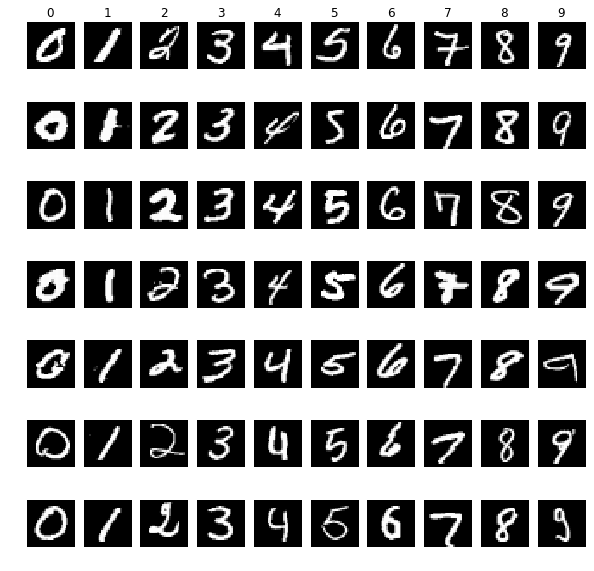

In [7]:
# Now let's visualise some of the images
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes): # y and cls takes values from 0-9
    idxs = np.flatnonzero(y_train == y) # gets the indices of samples that corresponds to class y
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # picks randomly samples_per_class indices
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1   # determines the sub-plot index
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### b. Classification of digits based on raw pixel values using SVM and different kernels

In [8]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
X_train, y_train = unison_shuffled_copies(X_train, y_train)
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # when reshaping, -1 means "infer target dims from orig dims
X_test = np.reshape(X_test, (X_test.shape[0], -1))    # in this case it flattens the (28,28,3) into 3072 
print(X_train.shape, X_test.shape)

(2000, 784) (100, 784)


#### Construct training folds for crossvalidation

In [9]:
num_folds = 10
c_choices = [1e-12, 1e-9, 1e-6, 1e-3, 1, 1e3]

X_train_folds = np.array_split(X_train,num_folds,axis=0)
y_train_folds = np.array_split(y_train,num_folds,axis=0)

X_train_folds = np.array(X_train_folds)
y_train_folds = np.array(y_train_folds)


#### Linear kernel cross-validation

In [10]:
c_to_accuracies = {}
for c in c_choices:
    c_to_accuracies[c] = np.zeros(num_folds)
    for f in range(num_folds):
        # Construct training set
        mask = (np.arange(num_folds) % num_folds  != 0)
        mask = np.roll(mask,shift=f)
        #print(mask)
        
        X_train_f = np.concatenate(X_train_folds[mask])
        y_train_f = np.concatenate(y_train_folds[mask])
        validation_f = X_train_folds[~mask][0]
        
        #print(c)
        clf = svm.LinearSVC(C=c,max_iter=10000)
        #clf = svm.SVC(kernel='linear',C=c)
        #clf = svm.SVC(C=c)
        #clf = svm.SVC(gamma='scale',kernel='linear',C=c)
        clf.fit(X_train_f, y_train_f)
        y_test_pred_f = clf.predict(validation_f)
        
        num_correct = np.sum(y_test_pred_f == y_train_folds[~mask])
        accuracy = float(num_correct) / len(validation_f)
        c_to_accuracies[c][f] = accuracy
        #print(accuracy)

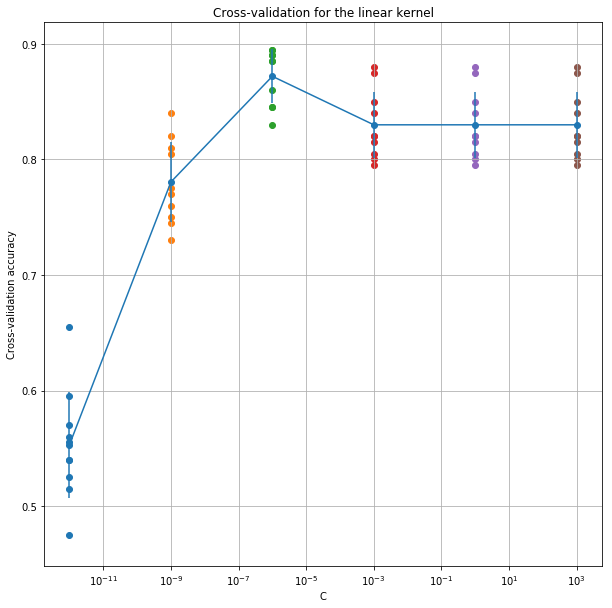

In [11]:
# plot the raw observations
for c in c_choices:
    accuracies = c_to_accuracies[c]
    plt.scatter([c] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(c_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(c_to_accuracies.items())])
plt.errorbar(c_choices, accuracies_mean, yerr=accuracies_std, fmt='-o')
plt.title('Cross-validation for the linear kernel')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Cross-validation accuracy')
plt.grid()
plt.show()

In [13]:
clf = svm.LinearSVC(C=1.0,max_iter=10000)
clf.fit(X_train, y_train)
labels_pred = clf.predict(X_test)
#labels_pred = np.argmax(data, axis=1)
correct_guesses = 0
for i,l in enumerate(y_test):
    if l==labels_pred[i]:
        correct_guesses += 1

acc = correct_guesses/len(y_test)
err = 1-acc
print('Overall error rate : {} %'.format(format(err*100,'.02f')))
cm = np.zeros((10,10)).astype(int)

for i,l in enumerate(y_test):
    cm[l,labels_pred[i]] += 1

Overall error rate : 11.00 %


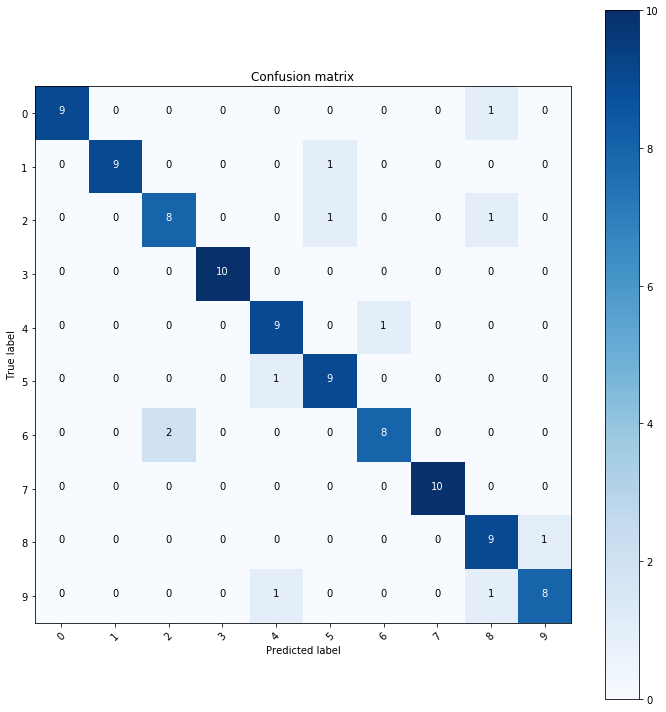

In [14]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

labels_str = [str(i) for i in range(10)]
plot_confusion_matrix(cm,labels_str)

#### Grid Search for Linear kernel

In [25]:
svc = svm.SVC()
parameters = {'kernel':['linear'], 'C':[1e-7, 1e-6, 1e-5]}
#return_train_score=False to improve performance
clf = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, n_jobs=-1, return_train_score=False)
clf.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ['linear'], 'C': [1e-07, 1e-06, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

param_C            1e-06
mean_test_score    0.908
Name: 1, dtype: object
Overall error rate : 8.00 %


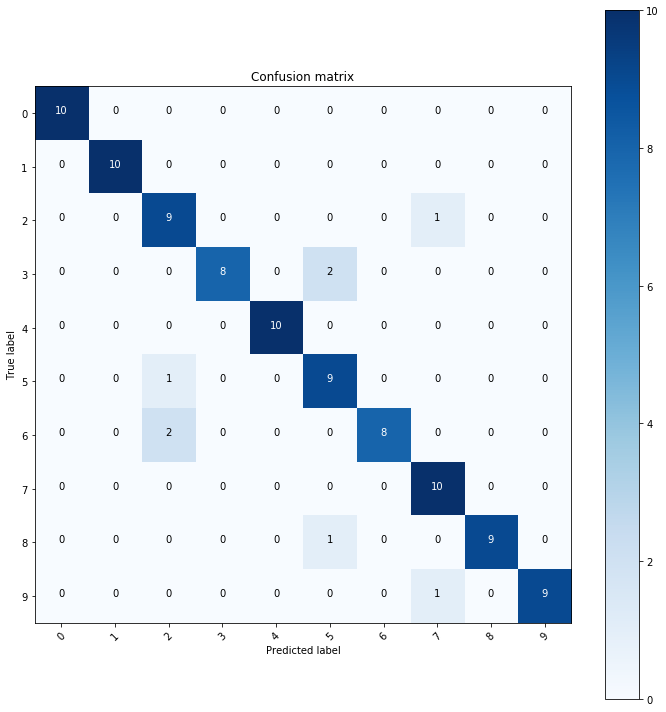

In [26]:
print(pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_][['param_C', 'mean_test_score']])
c = pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_]['param_C']

clf = svm.SVC(C=c, kernel='linear', max_iter=10000)
clf.fit(X_train, y_train)
labels_pred = clf.predict(X_test)
#labels_pred = np.argmax(data, axis=1)
correct_guesses = 0
for i,l in enumerate(y_test):
    if l==labels_pred[i]:
        correct_guesses += 1

acc = correct_guesses/len(y_test)
err = 1-acc
print('Overall error rate : {} %'.format(format(err*100,'.02f')))
cm = np.zeros((10,10)).astype(int)

for i,l in enumerate(y_test):
    cm[l,labels_pred[i]] += 1
    
labels_str = [str(i) for i in range(10)]
plot_confusion_matrix(cm,labels_str)

In [22]:
svc = svm.SVC()
# C and gamma = c_choices -> C=1000, gamma=1e-6
parameters = {'kernel':['rbf'], 'C':[10, 20, 30], 'gamma': [1e-8, 1e-7, 1e-6]}
#parameters = {'kernel': ['linear', 'poly', 'rbf'], 'C':[1, 10], 'gamma': [1, 10], 'degree':[1, 5]}
clf = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, n_jobs=-1, return_train_score=False)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'C': [10, 20, 30], 'gamma': [1e-08, 1e-07, 1e-06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

param_C                10
param_gamma         1e-07
mean_test_score    0.9305
Name: 1, dtype: object
Overall error rate : 2.00 %


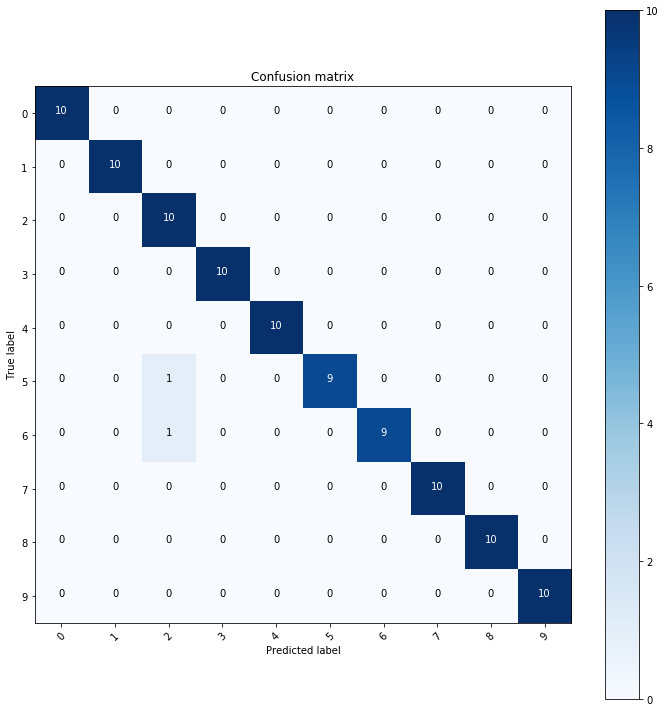

In [23]:
print(pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_][['param_C', 'param_gamma', 'mean_test_score']])
c = pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_]['param_C']
gamma = pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_]['param_gamma']

clf = svm.SVC(C=c, kernel='rbf', gamma=gamma, max_iter=10000)
clf.fit(X_train, y_train)
labels_pred = clf.predict(X_test)
#labels_pred = np.argmax(data, axis=1)
correct_guesses = 0
for i,l in enumerate(y_test):
    if l==labels_pred[i]:
        correct_guesses += 1

acc = correct_guesses/len(y_test)
err = 1-acc
print('Overall error rate : {} %'.format(format(err*100,'.02f')))
cm = np.zeros((10,10)).astype(int)

for i,l in enumerate(y_test):
    cm[l,labels_pred[i]] += 1
    
labels_str = [str(i) for i in range(10)]
plot_confusion_matrix(cm,labels_str)

In [27]:
svc = svm.SVC()
# C and gamma = c_choices -> C=1000, gamma=1e-6, 0.01, 0.1, 1
parameters = {'kernel':['poly'], 'C':[0.01, 0.1, 1], 'gamma':[1e-7, 1e-6, 1e-5], 'degree': [1, 2, 3]}
#parameters = {'kernel': ['linear', 'poly', 'rbf'], 'C':[1, 10], 'gamma': [1, 10], 'degree':[1, 5]}
clf = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, n_jobs=-1, return_train_score=False)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kernel': ['poly'], 'C': [0.01, 0.1, 1], 'gamma': [1e-07, 1e-06, 1e-05], 'degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

param_C               0.1
param_gamma         1e-06
param_degree            2
mean_test_score    0.9295
Name: 13, dtype: object
Overall error rate : 2.00 %


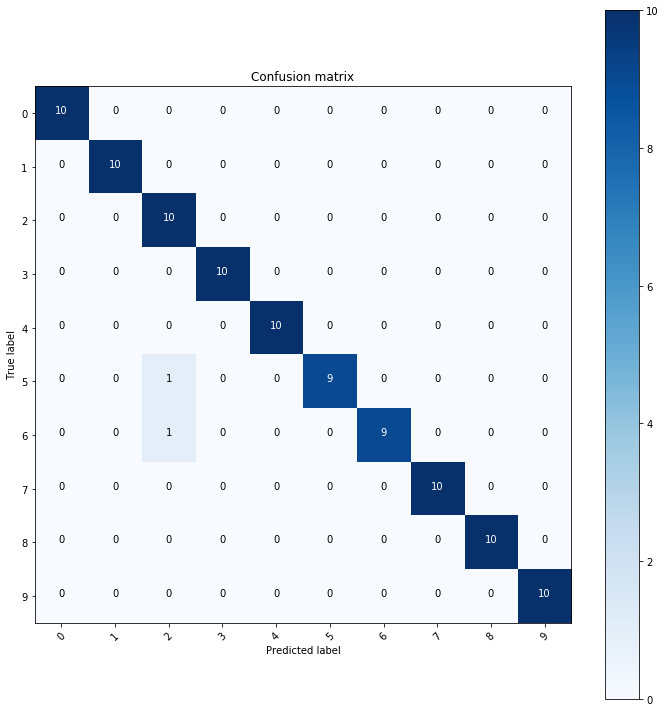

In [28]:
print(pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_][['param_C', 'param_gamma', 'param_degree', 'mean_test_score']])
c = pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_]['param_C']
gamma = pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_]['param_gamma']
degree = pd.DataFrame.from_dict(clf.cv_results_).iloc[clf.best_index_]['param_degree']

clf = svm.SVC(C=c, kernel='poly', gamma=gamma, degree=degree, max_iter=10000)
clf.fit(X_train, y_train)
labels_pred = clf.predict(X_test)
#labels_pred = np.argmax(data, axis=1)
correct_guesses = 0
for i,l in enumerate(y_test):
    if l==labels_pred[i]:
        correct_guesses += 1

acc = correct_guesses/len(y_test)
err = 1-acc
print('Overall error rate : {} %'.format(format(err*100,'.02f')))
cm = np.zeros((10,10)).astype(int)

for i,l in enumerate(y_test):
    cm[l,labels_pred[i]] += 1
    
labels_str = [str(i) for i in range(10)]
plot_confusion_matrix(cm,labels_str)

### d. Analysis of the results
Analyse the results obtained with the best SVM classifier.

#### a) Which kernel and parameters were used?

The best classifiers were using the RBF and polynomial kernels. 

**RBF kernel:** The C paramter as well as the $\gamma$ parameter needed to be chosen

**Polynomial kernel:** In addition to the two previous parameters, the degree of the polynome was chosen

#### b) Which digit classes are the best/worst recognized against which?

Both classifiers did two errors with the classes 5 and 6 by predicting a 2 instead. It's probably caused by some poorly written numbers. A test that uses a larger test set could show if this errors are recurrent. 

#### c) What is the impact of the sizes of the training and test sets on the classification performance?

When comparing with the Knn classifier (approx. 91% accuracy), these SVM could achieve 98 % accuracy by using about twice less training data.

